# 가설
“단일 모델보다 ensemble 모델이 더 높은 정확도와 f1-score를 보이며, num_words를 적절히 설정했을 때 모델 성능이 최적화된다.” 

In [32]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn 
from sklearn.metrics import f1_score

# 빈도수 상위n개 단어 설정
- 5000
- 10000
- 15000


In [2]:
# num_words = 5000
from keras.datasets import reuters
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

In [3]:
print(x_train[0]) # 인코딩된 데이터

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [4]:
print('훈련 샘플의 수 : {}'.format(len(x_train)))
print('테스트 샘플의 수 : {}'.format(len(x_test)))

훈련 샘플의 수 : 8982
테스트 샘플의 수 : 2246


In [5]:
#클래스 개수
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


## 데이터 분포 확인

훈련용 뉴스의 최대 길이 : 2376
훈련용 뉴스의 평균 길이 : 145.5398574927633


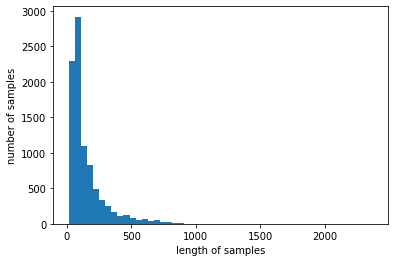

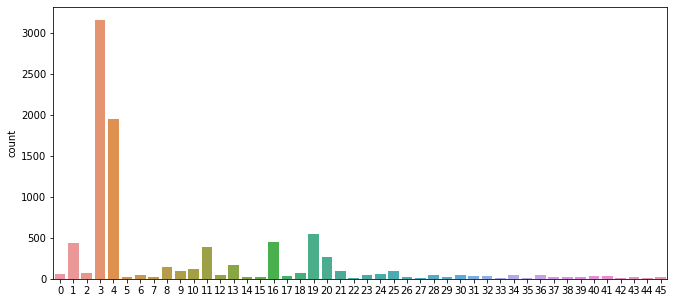

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [6]:
print('훈련용 뉴스의 최대 길이 : {}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 : {}'.format(sum(map(len, x_train))/len(x_train)))
plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

## 원본 뉴스로 복원하기

In [7]:
#정수 시퀸스로 되어있는 데이터를 텍스트 형태로 돌리기 위해 index_word 생성
word_index = reuters.get_word_index(path = 'reuters_word_index.json')
index_to_word = {index + 3 : word for word, index in word_index.items()}
# print(index_to_word[4])
# print(index_to_word[16])

In [8]:
#0은 <pad>, 1은<sos>, 2는 <unk>
for index, token in enumerate(('<pad>', '<sos>', '<unk>')):
    index_to_word[index] = token
    

In [9]:
# print(' '.join([index_to_word[index] for index in x_train[0]]))

In [10]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)
x_train = decoded
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))
print(len(x_train))

2246
8982


In [11]:
x_train[:2]

['<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 '<sos> generale de banque sa lt <unk> <unk> and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa <unk> factors generale de banque said in a statement it gave no financial details of the transaction sa <unk> <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3']

## 벡터화 하기

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [13]:
# x_tmp = [item[1] for item in x_train]

In [14]:
# DTM 생성
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

#TF-IDF생성
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 4867)
(8982, 4867)


# 1. 나이브 베이즈 분류기
- num_words = 5000
- 정확도: 0.6731967943009796
- f1-score:  0.6012501291711391

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

In [16]:
# print(tfidfv)

In [17]:
NB = MultinomialNB()
NB.fit(tfidfv, y_train)

MultinomialNB()

In [19]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

nb_predicted = NB.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, nb_predicted)) #예측값과 실제값 비교
print('f1-score: ', f1_score(y_test, nb_predicted, average='weighted'))  # f1-score 추가

정확도: 0.6731967943009796
f1-score:  0.6012501291711391


In [ ]:
probability_3 = NB.predict_proba(tfidfv_test[3])[0]

plt.rcParams["figure.figsize"] = (11,5)
plt.bar(NB.classes_, probability_3)
plt.xlim(-1, 21)
plt.xticks(NB.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

In [ ]:
NB.predict(tfidfv_test[3])

In [ ]:
# f1 = f1_score(y_test, y_pred, average='weighted')  # f1-score 추가

In [ ]:
# from sklearn.metrics import classification_report
# from sklearn.metrics import confusion_matrix
# def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
#     y_pred = model.predict(x_test)
#     cm = confusion_matrix(y_test, y_pred)
#     df_cm = pd.DataFrame(cm)
    
#     plt.figure(figsize=(12, 12))
#     heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
#     heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
#     heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.title('Confusion Matrix')
#     plt.show()


In [ ]:
# graph_confusion_matrix(NB, tfidfv_test, y_test)

# 1.1 나이브 베이즈 분류기
- num_words=10000, accuracy=0.6589, f1-score=0.5782
- num_words=15000, accuracy=0.6371, f1-score=0.5536

In [22]:
from tensorflow.keras.datasets import reuters
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, f1_score


def decode_review(sequence, reverse_word_index):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in sequence])

results = {}

for num_words in [10000, 15000]:
    # 데이터 로드
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)
    word_index = reuters.get_word_index()
    reverse_word_index = {v: k for k, v in word_index.items()}
    for index, token in enumerate(('<pad>', '<sos>', '<unk>')):
        reverse_word_index[index] = token

    # 숫자 → 텍스트 변환
    x_train_text = [decode_review(seq, reverse_word_index) for seq in x_train]
    x_test_text = [decode_review(seq, reverse_word_index) for seq in x_test]

    # DTM + TF-IDF
    vectorizer = CountVectorizer()
    x_train_dtm = vectorizer.fit_transform(x_train_text)
    x_test_dtm = vectorizer.transform(x_test_text)

    tfidf = TfidfTransformer()
    x_train_tfidf = tfidf.fit_transform(x_train_dtm)
    x_test_tfidf = tfidf.transform(x_test_dtm)

    # 모델 학습
    model = MultinomialNB()
    model.fit(x_train_tfidf, y_train)

    # 예측 및 평가
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # f1-score 추가
    results[num_words] = acc
    print(f'num_words={num_words}, accuracy={acc:.4f}')
    print(f'num_words={num_words}, f1-score={f1:.4f}')
    print(classification_report(y_test, y_pred, zero_division=0))
# 결과 확인
print(results)


num_words=10000, accuracy=0.6589
num_words=10000, f1-score=0.5782
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.62      0.71      0.66       105
           2       0.00      0.00      0.00        20
           3       0.81      0.90      0.85       813
           4       0.52      0.96      0.67       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.08      0.15        25
          10       0.00      0.00      0.00        30
          11       0.62      0.64      0.63        83
          12       0.00      0.00      0.00        13
          13       1.00      0.03      0.05        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16   

# 2. Voting
- soft/hard voting  

    확률 기반 : naive bayes, complement naive bayes  
    
    선형 기반 : logistic regression, svm  
    
    트리 기반 : decision tree, random forest, gradient boosting tree  
    
    
- Naive Bayes + Logistic Regression + Random Forest
- Naive Bayes + svm + Random Forest
- Complement Naive Bayes + SVM + Random Forest
- Logistic Regression + SVM + Gradient Boosting Tree

## 2.1 Naive Bayes + Logistic Regression + Random Forest
- num_words=5000, f1-score=0.7222, accuracy=0.7560
- num_words=10000, f1-score=0.6962, accuracy=0.7369
- num_words=15000, f1-score=0.6781, accuracy=0.7222

In [23]:
# Naive Bayes + Logistic Regression + Random Forest
for num_words in [5000, 10000, 15000]:
    # 데이터 로드
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)
    word_index = reuters.get_word_index()
    reverse_word_index = {v: k for k, v in word_index.items()}
    for index, token in enumerate(('<pad>', '<sos>', '<unk>')):
        reverse_word_index[index] = token
    # 숫자 → 텍스트 변환
    x_train_text = [decode_review(seq, reverse_word_index) for seq in x_train]
    x_test_text = [decode_review(seq, reverse_word_index) for seq in x_test]

    # DTM + TF-IDF
    vectorizer = CountVectorizer()
    x_train_dtm = vectorizer.fit_transform(x_train_text)
    x_test_dtm = vectorizer.transform(x_test_text)

    tfidf = TfidfTransformer()
    x_train_tfidf = tfidf.fit_transform(x_train_dtm)
    x_test_tfidf = tfidf.transform(x_test_dtm)

    # 모델 학습
    model = voting_clf = VotingClassifier(
        estimators=[
            ('nb', MultinomialNB()),
            ('lr', LogisticRegression()),
            ('rf', RandomForestClassifier())
        ],
        voting='soft'
    )
    model.fit(x_train_tfidf, y_train)

    # 예측 및 평가
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    results[num_words] = acc
    f1 = f1_score(y_test, y_pred, average='weighted')  # f1-score 추가
    print(f'num_words={num_words}, f1-score={f1:.4f}')
    print(f'num_words={num_words}, accuracy={acc:.4f}')
    print(classification_report(y_test, y_pred, zero_division=0))
# 결과 확인
print(results)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


num_words=5000, f1-score=0.7222
num_words=5000, accuracy=0.7560
              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.58      0.83      0.68       105
           2       1.00      0.25      0.40        20
           3       0.91      0.92      0.91       813
           4       0.67      0.94      0.78       474
           5       0.00      0.00      0.00         5
           6       1.00      0.50      0.67        14
           7       1.00      0.33      0.50         3
           8       0.81      0.45      0.58        38
           9       0.86      0.76      0.81        25
          10       0.94      0.57      0.71        30
          11       0.57      0.83      0.68        83
          12       0.50      0.08      0.13        13
          13       0.70      0.43      0.53        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16     

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


num_words=10000, f1-score=0.6962
num_words=10000, accuracy=0.7369
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.66      0.80      0.72       105
           2       1.00      0.20      0.33        20
           3       0.88      0.92      0.90       813
           4       0.61      0.94      0.74       474
           5       0.00      0.00      0.00         5
           6       1.00      0.14      0.25        14
           7       1.00      0.33      0.50         3
           8       0.75      0.39      0.52        38
           9       0.83      0.76      0.79        25
          10       0.94      0.50      0.65        30
          11       0.67      0.75      0.70        83
          12       0.67      0.15      0.25        13
          13       0.60      0.24      0.35        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16   

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


num_words=15000, f1-score=0.6781
num_words=15000, accuracy=0.7222
              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.70      0.77      0.73       105
           2       1.00      0.15      0.26        20
           3       0.85      0.92      0.89       813
           4       0.57      0.95      0.71       474
           5       0.00      0.00      0.00         5
           6       1.00      0.14      0.25        14
           7       1.00      0.33      0.50         3
           8       0.71      0.39      0.51        38
           9       0.94      0.60      0.73        25
          10       0.93      0.47      0.62        30
          11       0.74      0.71      0.72        83
          12       1.00      0.15      0.27        13
          13       0.50      0.16      0.24        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16   

## 2.2 Naive Bayes + svm + Random Forest
- svm 모델이 predict_proba를 지원하지 않으므로 voting = 'hard'
- num_words=5000, f1-score=0.7510, accuracy=0.7752
- num_words=10000, f1-score=0.7310, accuracy=0.7582
- num_words=15000, f1-score=0.7229, accuracy=0.7507

In [24]:
for num_words in [5000, 10000, 15000]:
    # 데이터 로드
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)
    word_index = reuters.get_word_index()
    reverse_word_index = {v: k for k, v in word_index.items()}
    for index, token in enumerate(('<pad>', '<sos>', '<unk>')):
        reverse_word_index[index] = token
    # 숫자 → 텍스트 변환
    x_train_text = [decode_review(seq, reverse_word_index) for seq in x_train]
    x_test_text = [decode_review(seq, reverse_word_index) for seq in x_test]

    # DTM + TF-IDF
    vectorizer = CountVectorizer()
    x_train_dtm = vectorizer.fit_transform(x_train_text)
    x_test_dtm = vectorizer.transform(x_test_text)

    tfidf = TfidfTransformer()
    x_train_tfidf = tfidf.fit_transform(x_train_dtm)
    x_test_tfidf = tfidf.transform(x_test_dtm)

    # 모델 학습
    model = voting_clf = VotingClassifier(
        estimators=[
            ('nb', MultinomialNB()),
            ('svm', LinearSVC()),
            ('rf', RandomForestClassifier())
        ],
        voting='hard'
    )
    model.fit(x_train_tfidf, y_train)

    # 예측 및 평가
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # f1-score 추가
    print(f'num_words={num_words}, f1-score={f1:.4f}')
    results[num_words] = acc
    print(f'num_words={num_words}, accuracy={acc:.4f}')
    print(classification_report(y_test, y_pred, zero_division=0))
# 결과 확인
print(results)

num_words=5000, f1-score=0.7510
num_words=5000, accuracy=0.7752
              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.56      0.84      0.67       105
           2       0.85      0.55      0.67        20
           3       0.91      0.92      0.92       813
           4       0.70      0.92      0.79       474
           5       0.00      0.00      0.00         5
           6       1.00      0.64      0.78        14
           7       1.00      0.33      0.50         3
           8       0.75      0.71      0.73        38
           9       0.85      0.68      0.76        25
          10       0.91      0.67      0.77        30
          11       0.61      0.81      0.69        83
          12       0.83      0.38      0.53        13
          13       0.61      0.46      0.52        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16     

## 2.3 Complement Naive Bayes + SVM + Random Forest
- num_words=5000, f1-score=0.7794, accuracy=0.7979
- num_words=10000, f1-score=0.7828, accuracy=0.8010
- num_words=15000, f1-score=0.7809, accuracy=0.7983

In [25]:
for num_words in [5000, 10000, 15000]:
    # 데이터 로드
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)
    word_index = reuters.get_word_index()
    reverse_word_index = {v: k for k, v in word_index.items()}
    for index, token in enumerate(('<pad>', '<sos>', '<unk>')):
        reverse_word_index[index] = token
    # 숫자 → 텍스트 변환
    x_train_text = [decode_review(seq, reverse_word_index) for seq in x_train]
    x_test_text = [decode_review(seq, reverse_word_index) for seq in x_test]

    # DTM + TF-IDF
    vectorizer = CountVectorizer()
    x_train_dtm = vectorizer.fit_transform(x_train_text)
    x_test_dtm = vectorizer.transform(x_test_text)

    tfidf = TfidfTransformer()
    x_train_tfidf = tfidf.fit_transform(x_train_dtm)
    x_test_tfidf = tfidf.transform(x_test_dtm)

    # 모델 학습
    model = voting_clf = VotingClassifier(
        estimators=[
            ('cb', ComplementNB()),
            ('svm', LinearSVC()),
            ('rf', RandomForestClassifier())
        ],
        voting='hard'
    )
    model.fit(x_train_tfidf, y_train)

    # 예측 및 평가
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    results[num_words] = acc
    f1 = f1_score(y_test, y_pred, average='weighted')  # f1-score 추가
    print(f'num_words={num_words}, f1-score={f1:.4f}')
    print(f'num_words={num_words}, accuracy={acc:.4f}')
    print(classification_report(y_test, y_pred, zero_division=0))
# 결과 확인
print(results)

num_words=5000, f1-score=0.7794
num_words=5000, accuracy=0.7979
              precision    recall  f1-score   support

           0       0.78      0.58      0.67        12
           1       0.59      0.85      0.70       105
           2       0.81      0.65      0.72        20
           3       0.92      0.92      0.92       813
           4       0.76      0.92      0.83       474
           5       0.00      0.00      0.00         5
           6       0.87      0.93      0.90        14
           7       1.00      0.33      0.50         3
           8       0.73      0.71      0.72        38
           9       0.85      0.88      0.86        25
          10       0.93      0.87      0.90        30
          11       0.62      0.82      0.71        83
          12       0.67      0.15      0.25        13
          13       0.69      0.59      0.64        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16     

## 2.4 Logistic Regression + SVM + Gradient Boosting Tree
- num_words=5000, f1-score=0.8100, accuracy=0.8215
- num_words=10000, f1-score=0.8075 accuracy=0.8179
- num_words=15000, f1-score=0.8088, accuracy=0.8197

In [26]:
for num_words in [5000, 10000, 15000]:
    # 데이터 로드
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)
    word_index = reuters.get_word_index()
    reverse_word_index = {v: k for k, v in word_index.items()}
    for index, token in enumerate(('<pad>', '<sos>', '<unk>')):
        reverse_word_index[index] = token
    # 숫자 → 텍스트 변환
    x_train_text = [decode_review(seq, reverse_word_index) for seq in x_train]
    x_test_text = [decode_review(seq, reverse_word_index) for seq in x_test]

    # DTM + TF-IDF
    vectorizer = CountVectorizer()
    x_train_dtm = vectorizer.fit_transform(x_train_text)
    x_test_dtm = vectorizer.transform(x_test_text)

    tfidf = TfidfTransformer()
    x_train_tfidf = tfidf.fit_transform(x_train_dtm)
    x_test_tfidf = tfidf.transform(x_test_dtm)

    # 모델 학습
    model = voting_clf = VotingClassifier(
        estimators=[
            ('lr', LogisticRegression()),
            ('svm', LinearSVC()),
            ('grbt', GradientBoostingClassifier())
        ],
        voting='hard'
    )
    model.fit(x_train_tfidf, y_train)

    # 예측 및 평가
    y_pred = model.predict(x_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    results[num_words] = acc
    f1 = f1_score(y_test, y_pred, average='weighted')  # f1-score 추가
    print(f'num_words={num_words}, f1-score={f1:.4f}')
    print(f'num_words={num_words}, accuracy={acc:.4f}')
    print(classification_report(y_test, y_pred, zero_division=0))
# 결과 확인
print(results)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


num_words=5000, f1-score=0.8100
num_words=5000, accuracy=0.8215
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.69      0.85      0.76       105
           2       0.79      0.75      0.77        20
           3       0.91      0.94      0.93       813
           4       0.79      0.91      0.84       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       0.67      0.67      0.67         3
           8       0.77      0.71      0.74        38
           9       0.85      0.88      0.86        25
          10       0.93      0.83      0.88        30
          11       0.67      0.78      0.72        83
          12       0.88      0.54      0.67        13
          13       0.65      0.59      0.62        37
          14       1.00      1.00      1.00         2
          15       0.00      0.00      0.00         9
          16     

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


num_words=10000, f1-score=0.8075
num_words=10000, accuracy=0.8179
              precision    recall  f1-score   support

           0       0.80      0.67      0.73        12
           1       0.71      0.83      0.76       105
           2       0.80      0.80      0.80        20
           3       0.91      0.94      0.93       813
           4       0.77      0.91      0.84       474
           5       0.00      0.00      0.00         5
           6       0.86      0.86      0.86        14
           7       1.00      0.33      0.50         3
           8       0.75      0.71      0.73        38
           9       0.91      0.84      0.87        25
          10       0.93      0.83      0.88        30
          11       0.67      0.78      0.72        83
          12       0.88      0.54      0.67        13
          13       0.71      0.59      0.65        37
          14       0.67      1.00      0.80         2
          15       0.00      0.00      0.00         9
          16   

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


num_words=15000, f1-score=0.8088
num_words=15000, accuracy=0.8197
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.68      0.85      0.75       105
           2       0.83      0.75      0.79        20
           3       0.91      0.94      0.93       813
           4       0.78      0.91      0.84       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.33      0.50         3
           8       0.77      0.71      0.74        38
           9       0.91      0.84      0.87        25
          10       0.93      0.87      0.90        30
          11       0.67      0.77      0.72        83
          12       0.88      0.54      0.67        13
          13       0.71      0.59      0.65        37
          14       1.00      0.50      0.67         2
          15       0.50      0.11      0.18         9
          16   

In [28]:
def run_experiment(model, num_words_list = [5000, 10000, 15000]):
    results = {}
    f1_results = {}
    
    for num_words in num_words_list:
        # 데이터 로드
        (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)
        word_index = reuters.get_word_index()
        reverse_word_index = {v: k for k, v in word_index.items()}
        for index, token in enumerate(('<pad>', '<sos>', '<unk>')):
            reverse_word_index[index] = token
        
        # 숫자 → 텍스트 변환
        x_train_text = [decode_review(seq, reverse_word_index) for seq in x_train]
        x_test_text = [decode_review(seq, reverse_word_index) for seq in x_test]

        # DTM + TF-IDF
        vectorizer = CountVectorizer()
        x_train_dtm = vectorizer.fit_transform(x_train_text)
        x_test_dtm = vectorizer.transform(x_test_text)

        tfidf = TfidfTransformer()
        x_train_tfidf = tfidf.fit_transform(x_train_dtm)
        x_test_tfidf = tfidf.transform(x_test_dtm)

        # 모델 학습
        model.fit(x_train_tfidf, y_train)

        # 예측 및 평가
        y_pred = model.predict(x_test_tfidf)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
    
        results[num_words] = acc
        f1_results[num_words] = f1
    
        print(f'num_words={num_words}, accuracy={acc:.4f}, f1-score={f1:.4f}')
        print(classification_report(y_test, y_pred, zero_division=0))

    return results, f1_results

# 나이브 베이즈, 보팅 결과
| 모델           | num\_words | Accuracy | F1-score |
| -------------- | ---------- | -------- | -------- |
| Naive Bayes    | 5000       | 0.6732   | 0.6013   |
| Naive Bayes    | 10000      | 0.6589   | 0.5782   |
| Naive Bayes    | 15000      | 0.6371   | 0.5536   |
| NB + LR + RF   | 5000       | 0.7560   | 0.7222   |
| NB + LR + RF   | 10000      | 0.7369   | 0.6962   |
| NB + LR + RF   | 15000      | 0.7222   | 0.6781   |
| NB + SVM + RF  | 5000       | 0.7752   | 0.7510   |
| NB + SVM + RF  | 10000      | 0.7582   | 0.7310   |
| NB + SVM + RF  | 15000      | 0.7507   | 0.7229   |
| CNB + SVM + RF | 5000       | 0.7979   | 0.7794   |
| CNB + SVM + RF | 10000      | 0.8010   | 0.7828   |
| CNB + SVM + RF | 15000      | 0.7983   | 0.7809   |
| LR + SVM + GBT | 5000       | 0.8215   | 0.8100   |
| LR + SVM + GBT | 10000      | 0.8179   | 0.8075   |
| LR + SVM + GBT | 15000      | 0.8197   | 0.8088   |

- Voting > 단일 모델: Ensemble의 강력함 입증
- num_words는 5000~10000이 optimal, 15000은 성능 개선 거의 없음 + 비용 증가
    - 단어 집합이 커질수록 희소성 증가, noise 유입
    - voting 모델들은 하락폭이 작아 robust
- Naive Bayes: f1-score가 accuracy보다 훨씬 낮음 -> 소수 클래스 예측 실패
- voting 모델은 f1-score도 높음 -> 전체 클래스 예측 균형을 잘 맞춤
- LR + SVM + GBT + 5000 num_words 최고 성능

###  모델별 성능 추이
| 모델             | 5000 | 10000 | 15000  |
| -------------- | ---- | ----- | ------ |
| Naive Bayes    | 최고   | ↓ 감소  | ↓ 더 감소 |
| NB + LR + RF   | 최고   | ↓ 감소  | ↓ 더 감소 |
| NB + SVM + RF  | 최고   | ↓ 감소  | ↓ 더 감소 |
| CNB + SVM + RF | 비슷   | 소폭 상승 | 유지     |
| LR + SVM + GBT | 최고   | 미세 하락 | 유지     |


- 공통적으로 5000에서 최고 성능
- CNB + SVM + RF과 LR + SVM + GBT의 안정성 -> num_words 변화에 거의 영향을 받지 않음

# num_words = 3000로 줄여보자

In [29]:
# 1. Naive Bayes
results_nb, f1_nb = run_experiment(MultinomialNB(), num_words_list=[3000])

# 2. NB + LR + RF
model_nblrrf = VotingClassifier(
    estimators=[
        ('nb', MultinomialNB()),
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier())
    ],
    voting='soft'
)
results_nblrrf, f1_nblrrf = run_experiment(model_nblrrf, num_words_list=[3000])

# 3. NB + SVM + RF (SVM 때문에 hard voting)
model_nbsvmrf = VotingClassifier(
    estimators=[
        ('nb', MultinomialNB()),
        ('svm', LinearSVC()),
        ('rf', RandomForestClassifier())
    ],
    voting='hard'
)
results_nbsvmrf, f1_nbsvmrf = run_experiment(model_nbsvmrf, num_words_list=[3000])

# 4. CNB + SVM + RF
model_cnbsvmrf = VotingClassifier(
    estimators=[
        ('cnb', ComplementNB()),
        ('svm', LinearSVC()),
        ('rf', RandomForestClassifier())
    ],
    voting='hard'
)
results_cnbsvmrf, f1_cnbsvmrf = run_experiment(model_cnbsvmrf, num_words_list=[3000])

# 5. LR + SVM + GBT
model_lrsvmgbt = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('svm', LinearSVC()),
        ('gbt', GradientBoostingClassifier())
    ],
    voting='hard'
)
results_lrsvmgbt, f1_lrsvmgbt = run_experiment(model_lrsvmgbt, num_words_list=[3000])


num_words=3000, accuracy=0.6910, f1-score=0.6334
              precision    recall  f1-score   support

           0       1.00      0.25      0.40        12
           1       0.48      0.83      0.61       105
           2       0.00      0.00      0.00        20
           3       0.88      0.88      0.88       813
           4       0.66      0.94      0.77       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.48      0.65        25
          10       1.00      0.17      0.29        30
          11       0.44      0.77      0.56        83
          12       0.00      0.00      0.00        13
          13       0.75      0.24      0.37        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.55      0.7

num_words=3000, accuracy=0.8041, f1-score=0.7846
              precision    recall  f1-score   support

           0       0.78      0.58      0.67        12
           1       0.63      0.87      0.73       105
           2       0.80      0.60      0.69        20
           3       0.93      0.92      0.93       813
           4       0.76      0.92      0.83       474
           5       0.00      0.00      0.00         5
           6       0.87      0.93      0.90        14
           7       1.00      0.33      0.50         3
           8       0.71      0.63      0.67        38
           9       0.85      0.88      0.86        25
          10       0.90      0.90      0.90        30
          11       0.64      0.83      0.73        83
          12       0.67      0.15      0.25        13
          13       0.67      0.65      0.66        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.72      0.7

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# 실험 결과를 하나로 통합
all_results = {
    'Naive Bayes': (results_nb, f1_nb),
    'NB + LR + RF': (results_nblrrf, f1_nblrrf),
    'NB + SVM + RF': (results_nbsvmrf, f1_nbsvmrf),
    'CNB + SVM + RF': (results_cnbsvmrf, f1_cnbsvmrf),
    'LR + SVM + GBT': (results_lrsvmgbt, f1_lrsvmgbt)
}

# ✅ DataFrame으로 변환
rows = []
for model_name, (acc_dict, f1_dict) in all_results.items():
    for num_words in acc_dict.keys():
        rows.append({
            'Model': model_name,
            'num_words': num_words,
            'Accuracy': round(acc_dict[num_words], 4),
            'F1-score': round(f1_dict[num_words], 4)
        })

results_df = pd.DataFrame(rows)
results_df = results_df.sort_values(by=['Model', 'num_words']).reset_index(drop=True)

# ✅ 결과 테이블 출력
print(results_df)



            Model  num_words  Accuracy  F1-score
0  CNB + SVM + RF       3000    0.8041    0.7846
1  LR + SVM + GBT       3000    0.8192    0.8089
2    NB + LR + RF       3000    0.7676    0.7380
3   NB + SVM + RF       3000    0.7845    0.7624
4     Naive Bayes       3000    0.6910    0.6334


## num_words 감소 효과 확인(3000 vs 5000~15000)
| 모델             | 3000            | 5000~15000                     | 효과                |
| -------------- | --------------- | ------------------------------- | ----------------- |
| Naive Bayes    | 0.6910 / 0.6334 | 0.6371 ~ 0.6732 / 0.5536 ~ 0.6013 | 3000에서 **명확한 향상** |
| NB + LR + RF   | 0.7676 / 0.7380 | 0.7222 ~ 0.7560 / 0.6781 ~ 0.7222 | **3000 최고**       |
| NB + SVM + RF  | 0.7845 / 0.7624 | 0.7507 ~ 0.7752 / 0.7229 ~ 0.7510 | **3000 최고**       |
| CNB + SVM + RF | 0.8041 / 0.7846 | 0.7979 ~ 0.8010 / 0.7794 ~ 0.7828 | 큰 차이 없음 (매우 안정)   |
| LR + SVM + GBT | 0.8192 / 0.8089 | 0.8179 ~ 0.8215 / 0.8075 ~ 0.8100 | 거의 동일 (안정성 최고)    |



## 모델별 특성 요약
| 모델             | 특성                           |
| -------------- | ---------------------------- |
| Naive Bayes    | 단일 모델 → feature 수 줄일 때 가장 개선 |
| NB + LR + RF   | 기본 Voting → 3000에서 가장 강함     |
| NB + SVM + RF  | SVM 추가 → 3000에서 가장 강함        |
| CNB + SVM + RF | 불균형 데이터, 희소성 강인 → 매우 안정      |
| LR + SVM + GBT | 최고 성능 + 최고 안정성 → 전체 Best 모델, 5000에서 가장 강함|


# 딥러닝 모델 적용
- maxlen = 300
- model: lstm, num_words: 5000, accuracy: 0.6109, f1-score: 0.5635
- model: bilstm, num_words: 5000, accuracy: 0.5850, f1-score: 0.5317
- model: cnn, num_words: 5000, accuracy: 0.7912, f1-score: 0.7736
- Logistic Regression + SVM + Gradient Boosting Tree
    num_words=5000, f1-score=0.8100, accuracy=0.8215

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, classification_report

def run_deep_learning_experiment(num_words=5000, maxlen=300, model_type='lstm'):
    # 1. 데이터 로드
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=0.2)
    
    # 2. 시퀀스 패딩
    x_train = pad_sequences(x_train, maxlen=maxlen)
    x_test = pad_sequences(x_test, maxlen=maxlen)

    # 3. 모델 생성
    model = Sequential()
    model.add(Embedding(input_dim=num_words, output_dim=128, input_length=maxlen))

    if model_type == 'lstm':
        model.add(LSTM(64))
    elif model_type == 'bilstm':
        from tensorflow.keras.layers import Bidirectional
        model.add(Bidirectional(LSTM(64)))
    elif model_type == 'cnn':
        model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
        model.add(GlobalMaxPooling1D())
    else:
        raise ValueError("model_type은 'lstm', 'bilstm', 'cnn' 중 하나여야 합니다.")
    
    model.add(Dense(46, activation='softmax'))  # Reuters는 46 classes

    # 4. 컴파일 및 학습
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(x_train, y_train,
              epochs=10,
              batch_size=128,
              validation_split=0.2,
              callbacks=[early_stop],
              verbose=2)

    # 5. 평가
    y_pred_prob = model.predict(x_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"model: {model_type}, num_words: {num_words}, accuracy: {acc:.4f}, f1-score: {f1:.4f}")
    print(classification_report(y_test, y_pred, zero_division=0))

    return acc, f1


In [35]:
# LSTM 모델
run_deep_learning_experiment(num_words=5000, model_type='lstm')

Epoch 1/10
57/57 - 2s - loss: 2.8704 - accuracy: 0.3431 - val_loss: 2.4016 - val_accuracy: 0.3450
Epoch 2/10
57/57 - 1s - loss: 2.2590 - accuracy: 0.4203 - val_loss: 2.0723 - val_accuracy: 0.4942
Epoch 3/10
57/57 - 1s - loss: 2.0542 - accuracy: 0.4926 - val_loss: 1.9987 - val_accuracy: 0.5036
Epoch 4/10
57/57 - 1s - loss: 1.8724 - accuracy: 0.5296 - val_loss: 1.8380 - val_accuracy: 0.5203
Epoch 5/10
57/57 - 1s - loss: 1.6586 - accuracy: 0.5770 - val_loss: 1.6360 - val_accuracy: 0.5843
Epoch 6/10
57/57 - 1s - loss: 1.5361 - accuracy: 0.6134 - val_loss: 1.5533 - val_accuracy: 0.6144
Epoch 7/10
57/57 - 1s - loss: 1.4201 - accuracy: 0.6480 - val_loss: 1.6397 - val_accuracy: 0.5860
Epoch 8/10
57/57 - 1s - loss: 1.4663 - accuracy: 0.6262 - val_loss: 1.5403 - val_accuracy: 0.6283
Epoch 9/10
57/57 - 1s - loss: 1.2958 - accuracy: 0.6720 - val_loss: 1.4732 - val_accuracy: 0.6366
Epoch 10/10
57/57 - 1s - loss: 1.2504 - accuracy: 0.6839 - val_loss: 1.5487 - val_accuracy: 0.6166
model: lstm, num_wo

(0.6108637577916296, 0.5634710670155165)

In [36]:
# bilstm 모델
run_deep_learning_experiment(num_words=5000, model_type='bilstm')

Epoch 1/10
57/57 - 4s - loss: 2.5719 - accuracy: 0.3777 - val_loss: 1.9945 - val_accuracy: 0.4814
Epoch 2/10
57/57 - 1s - loss: 1.8323 - accuracy: 0.5100 - val_loss: 1.9123 - val_accuracy: 0.4814
Epoch 3/10
57/57 - 1s - loss: 2.0774 - accuracy: 0.4618 - val_loss: 2.0946 - val_accuracy: 0.4886
Epoch 4/10
57/57 - 1s - loss: 2.0149 - accuracy: 0.5035 - val_loss: 1.9978 - val_accuracy: 0.5036
Epoch 5/10
57/57 - 1s - loss: 1.9113 - accuracy: 0.5165 - val_loss: 1.8514 - val_accuracy: 0.5186
Epoch 6/10
57/57 - 1s - loss: 1.7605 - accuracy: 0.5484 - val_loss: 1.7084 - val_accuracy: 0.5671
Epoch 7/10
57/57 - 1s - loss: 1.6564 - accuracy: 0.5846 - val_loss: 1.6658 - val_accuracy: 0.5732
Epoch 8/10
57/57 - 1s - loss: 1.6247 - accuracy: 0.5882 - val_loss: 1.6629 - val_accuracy: 0.5893
Epoch 9/10
57/57 - 1s - loss: 1.6102 - accuracy: 0.5986 - val_loss: 1.6769 - val_accuracy: 0.5815
Epoch 10/10
57/57 - 1s - loss: 1.5839 - accuracy: 0.6017 - val_loss: 1.6464 - val_accuracy: 0.5860
model: bilstm, num_

(0.585040071237756, 0.5317431165409485)

In [37]:
# cnn 모델
run_deep_learning_experiment(num_words=5000, model_type='cnn')

Epoch 1/10
57/57 - 23s - loss: 2.5779 - accuracy: 0.4188 - val_loss: 1.8949 - val_accuracy: 0.5081
Epoch 2/10
57/57 - 1s - loss: 1.6875 - accuracy: 0.5896 - val_loss: 1.5068 - val_accuracy: 0.6706
Epoch 3/10
57/57 - 1s - loss: 1.3204 - accuracy: 0.6988 - val_loss: 1.2668 - val_accuracy: 0.7095
Epoch 4/10
57/57 - 1s - loss: 1.0792 - accuracy: 0.7457 - val_loss: 1.1424 - val_accuracy: 0.7385
Epoch 5/10
57/57 - 1s - loss: 0.9004 - accuracy: 0.7854 - val_loss: 1.0380 - val_accuracy: 0.7641
Epoch 6/10
57/57 - 1s - loss: 0.7490 - accuracy: 0.8195 - val_loss: 0.9635 - val_accuracy: 0.7774
Epoch 7/10
57/57 - 1s - loss: 0.6190 - accuracy: 0.8472 - val_loss: 0.9067 - val_accuracy: 0.7863
Epoch 8/10
57/57 - 1s - loss: 0.5065 - accuracy: 0.8745 - val_loss: 0.8733 - val_accuracy: 0.7986
Epoch 9/10
57/57 - 1s - loss: 0.4064 - accuracy: 0.8987 - val_loss: 0.8566 - val_accuracy: 0.8019
Epoch 10/10
57/57 - 1s - loss: 0.3264 - accuracy: 0.9200 - val_loss: 0.8517 - val_accuracy: 0.8036
model: cnn, num_wo

(0.7911843276936776, 0.7735816624506641)

# 딥러닝 모델과 비교
| 모델                           | Accuracy   | F1-score   |
| ---------------------------- | ---------- | ---------- |
| LSTM                         | 0.6109     | 0.5635     |
| Bi-LSTM                      | 0.5850     | 0.5317     |
| CNN                          | 0.7912     | 0.7736     |
| LR + SVM + GBT (ML voting) | **0.8215** | **0.8100** |

- 딥러닝은 Reuters와 같은 small dataset에 적합하지 않음
- RNN 계열 성능 저조
- CNN의 상대적 선전
- ML ensemble (LR + SVM + GBT) = 최종 Best Model  

    highest accuracy

    highest f1-score

    highest stability across classes

# 최종 통합 표
| 모델                       | 5000 Acc / F1       | 10000 Acc / F1  | 15000 Acc / F1  |
| ------------------------ | ------------------- | --------------- | --------------- |
| **전통 ML 단일 모델**          |                     |                 |                 |
| Decision Tree (dtree)    | 0.618 / 0.573       | 0.6202 / 0.5776 | 0.6193 / 0.5756 |
| Naive Bayes              | 0.6732 / 0.6013     | 0.6589 / 0.5782 | 0.6371 / 0.5536 |
| Complement Naive Bayes   | 0.7707 / 0.7459     | 0.7707 / 0.7457 | 0.772 / 0.7448  |
| SVM                      | 0.7752 / 0.7721     | 0.7881 / 0.7844 | 0.7885 / 0.7837 |
| Random Forest            | 0.70 / 0.68         | 0.67 / 0.64     | 0.81 / 0.81     |
| Gradient Boosting        | 0.7676 / 0.7662     | 0.7663 / 0.7622 | 0.7707 / 0.7680 |
| Logistic Regression (L2) | 0.80 / 0.80         | 0.81 / 0.81     | 0.67 / 0.64     |
| **ML Ensemble voting**   |                     |                 |                 |
| NB + LR + RF             | 0.7560 / 0.7222     | 0.7369 / 0.6962 | 0.7222 / 0.6781 |
| NB + SVM + RF            | 0.7752 / 0.7510     | 0.7582 / 0.7310 | 0.7507 / 0.7229 |
| CNB + SVM + RF           | 0.7979 / 0.7794     | 0.8010 / 0.7828 | 0.7983 / 0.7809 |
| LR + SVM + GBT           | **0.8215 / 0.8100** | 0.8179 / 0.8075 | 0.8197 / 0.8088 |
| **딥러닝 모델**         |                     |                 |                 |
| LSTM                     | 0.6109 / 0.5635     | 0.64/0.62       | -               |
| Bi-LSTM                  | 0.5850 / 0.5317     | -               | -               |
| CNN                      | 0.7912 / 0.7736     | -               | -               |

| 단어 수 (vocab size) | 평균 Accuracy | 평균 F1-score | 요약 평가 |
|----------------------|---------------|---------------|------------|
| 5,000                | 0.7357        | 0.7102        | ⚪ 안정적이나 약간 부족 |
| 10,000               | 0.7399        | 0.7135        | 🟢 가장 균형 좋고 성능 우수 |
| 15,000               | 0.7334        | 0.7041        | 🟡 일부 모델은 좋지만 평균은 하락 |





-  단일모델로 보았을 때 SVM과 LR이 가장 높은 성능을 보임
- 복합모델로는 SVM과 LR이 포함된 보팅모델이 가장 높은 성능을 보였다.
- 가장 높은 성능을 보인것은 단어 수 5000에 복합모델이지만 평균적으로 좋은 성능을 보이는 단어 수는 10,000으로 확인됨


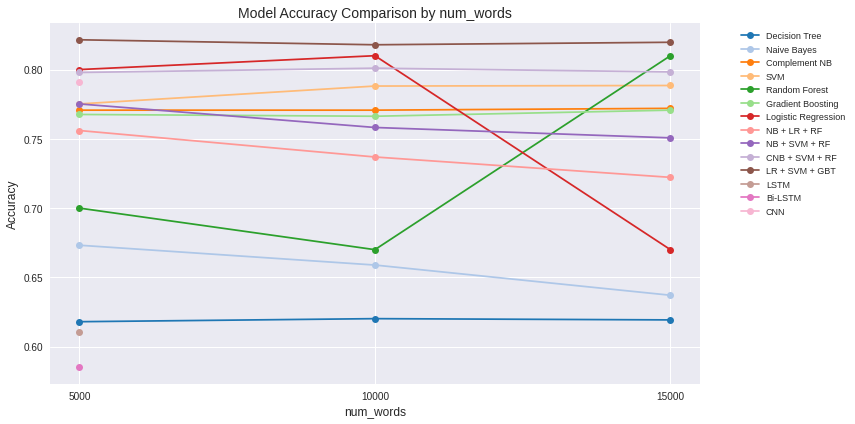

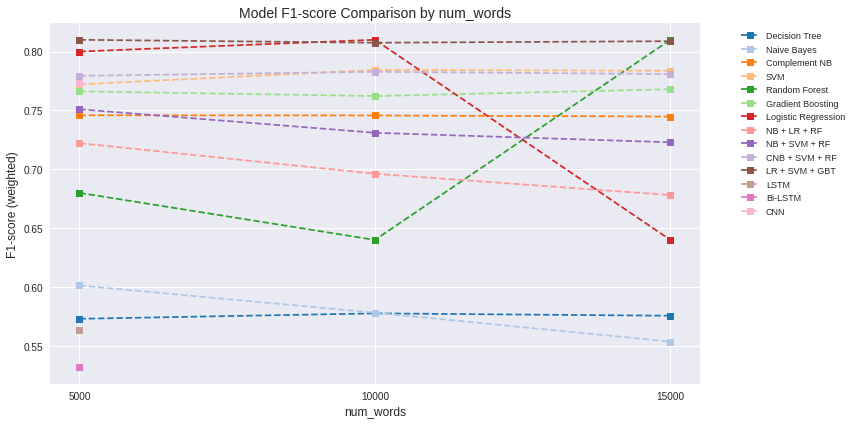

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터프레임 정의
data = {
    'Model': [
        'Decision Tree', 'Naive Bayes', 'Complement NB', 'SVM', 'Random Forest',
        'Gradient Boosting', 'Logistic Regression',
        'NB + LR + RF', 'NB + SVM + RF', 'CNB + SVM + RF', 'LR + SVM + GBT',
        'LSTM', 'Bi-LSTM', 'CNN'
    ],
    '5000_Acc': [0.618, 0.6732, 0.7707, 0.7752, 0.70, 0.7676, 0.80,
                 0.7560, 0.7752, 0.7979, 0.8215, 0.6109, 0.5850, 0.7912],
    '10000_Acc': [0.6202, 0.6589, 0.7707, 0.7881, 0.67, 0.7663, 0.81,
                  0.7369, 0.7582, 0.8010, 0.8179, None, None, None],
    '15000_Acc': [0.6193, 0.6371, 0.772, 0.7885, 0.81, 0.7707, 0.67,
                  0.7222, 0.7507, 0.7983, 0.8197, None, None, None],
    '5000_F1': [0.573, 0.6013, 0.7459, 0.7721, 0.68, 0.7662, 0.80,
                0.7222, 0.7510, 0.7794, 0.8100, 0.5635, 0.5317, 0.7736],
    '10000_F1': [0.5776, 0.5782, 0.7457, 0.7844, 0.64, 0.7622, 0.81,
                 0.6962, 0.7310, 0.7828, 0.8075, None, None, None],
    '15000_F1': [0.5756, 0.5536, 0.7448, 0.7837, 0.81, 0.7680, 0.64,
                 0.6781, 0.7229, 0.7809, 0.8088, None, None, None]
}

df = pd.DataFrame(data)

# 발표용 스타일 적용
plt.style.use('seaborn')
colors = plt.cm.tab20.colors

# Accuracy 그래프
plt.figure(figsize=(12, 6))
for i, row in df.iterrows():
    x = [5000, 10000, 15000]
    y = [row['5000_Acc'], row['10000_Acc'], row['15000_Acc']]
    if any(pd.notna(y)):
        plt.plot(x, y, marker='o', label=row['Model'], color=colors[i % len(colors)])

plt.title('Model Accuracy Comparison by num_words', fontsize=14)
plt.xlabel('num_words', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks([5000, 10000, 15000])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

# F1-score 그래프
plt.figure(figsize=(12, 6))
for i, row in df.iterrows():
    x = [5000, 10000, 15000]
    y = [row['5000_F1'], row['10000_F1'], row['15000_F1']]
    if any(pd.notna(y)):
        plt.plot(x, y, marker='s', linestyle='--', label=row['Model'], color=colors[i % len(colors)])

plt.title('Model F1-score Comparison by num_words', fontsize=14)
plt.xlabel('num_words', fontsize=12)
plt.ylabel('F1-score (weighted)', fontsize=12)
plt.xticks([5000, 10000, 15000])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()


# 회고
- 뉴스 데이터셋에서 num_words와 voting 모델 조합에 따라 분류 성능이 어떻게 변화하는지 분석하였다. 
- num_words가 5000에서 최고 성능을 보일것이라고 예상했으나 3000으로 줄인 후에도 성능이 향상되거나 유지되었다. 
- 모든 모델에서 10000 > 5000 > 15000 이 평균적으로 좋았다. 
- 단일 보델에서 가장 성능이 좋았던 svm, logistic regression을 조합한 lr + svm + gbt 모델이 성능이 좋았다. 
- voting에서 linearSVC때문에 hard voting을 사용. 
- soft/hard voting 비교 실험을 하면 좋을 것 같다. 